In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error

## Importing data and preparing it for ML

In [3]:
#import cleaned data
df = pd.read_csv("joined_data.csv")
df = df.drop(['Unnamed: 0'], axis=1)
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,room_type_Shared room,number_of_places_2500m,number_of_places_1000m,number_of_places_500m,number_of_rats_2500m,number_of_rats_1000m,number_of_rats_500m,number_of_trees_2500m,number_of_trees_1000m,number_of_trees_500m
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,0.0,8,0,0,456,57,8,5491,1037,321
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.0,75,29,4,448,54,5,3611,296,46


In [4]:
#manage Na values in dataframe
df.isna().sum()

id                                      0
name                                   15
host_id                                 0
host_name                              21
neighbourhood_group                     0
neighbourhood                           0
latitude                                0
longitude                               0
room_type                               0
price                                   0
minimum_nights                          0
number_of_reviews                       0
last_review                          9913
reviews_per_month                    9913
calculated_host_listings_count          0
availability_365                        0
neighbourhood_other                     0
neighbourhood_other_label               0
neighbourhood_group_Bronx               0
neighbourhood_group_Brooklyn            0
neighbourhood_group_Manhattan           0
neighbourhood_group_Queens              0
neighbourhood_group_Staten Island       0
room_type_Entire home/apt         

In [5]:
print(df[df['last_review'].isna()].groupby('number_of_reviews').size())
print(df[df['reviews_per_month'].isna()].groupby('number_of_reviews').size())

number_of_reviews
0    9913
dtype: int64
number_of_reviews
0    9913
dtype: int64


In [6]:
df['last_review'] = df['last_review'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [7]:
# df[df.isna().any(axis=1)].head()
# df=df.dropna()#drop remaining 37 Nan values, 16 from name and 21 from host name 

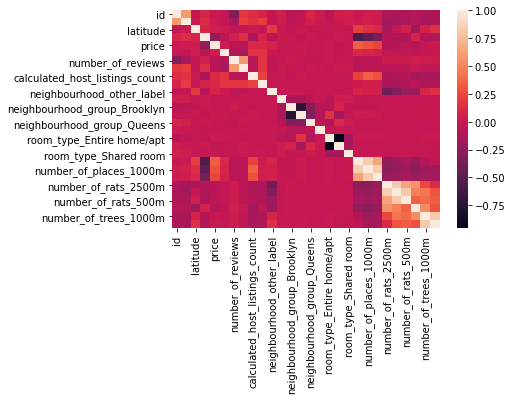

In [8]:
#correlation matrix giving an overview of how our colums relate to one another
sns.heatmap(df.corr())
plt.show()

### Making datasets for the machine learning algorithm

In [9]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'number_of_places_2500m', 'number_of_places_1000m',
       'number_of_places_500m', 'number_of_rats_2500m', 'number_of_rats_1000m',
       'number_of_rats_500m', 'number_of_trees_2500m', 'number_of_trees_1000m',
       'number_of_trees_500m'],
      dtype='object')

In [10]:
#chose which featues not to include in the calculation
features = df.drop(['price',
                    'id', 
                    'name', 
                    'host_id', 
                    'host_name', 
                    'neighbourhood_group',
                    'neighbourhood', 
                    'room_type',
                    'last_review',#dropped until we encode it to not datetime
                    'neighbourhood_other'], axis=1)
target = df.price

print(features.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'number_of_places_2500m', 'number_of_places_1000m',
       'number_of_places_500m', 'number_of_rats_2500m', 'number_of_rats_1000m',
       'number_of_rats_500m', 'number_of_trees_2500m', 'number_of_trees_1000m',
       'number_of_trees_500m'],
      dtype='object')


## Baseline model linear regression

In [11]:
scaler = StandardScaler()
base_features = scaler.fit_transform(features)

test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(base_features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 25) 	Testing Features Shape:	 (9743, 25)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [12]:
reg_lin = LinearRegression().fit(X_train, y_train)
y_pred = reg_lin.predict(X_test)
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 75.0061


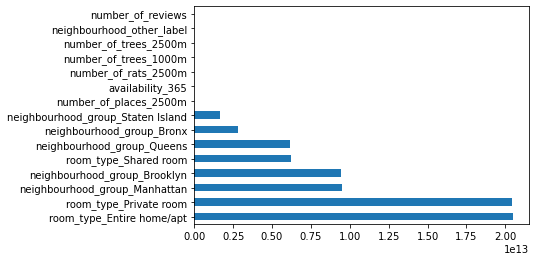

In [13]:
pd.Series(np.abs(reg_lin.coef_), index=features.columns).nlargest(15).plot(kind='barh')
plt.show()

## Decision Tree

In [14]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 25) 	Testing Features Shape:	 (9743, 25)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [15]:
parameters = {'criterion':('mse', 'poisson'), 'max_depth':[1, 5, 10, 15, 20]} #'friedman_mse' gives same results as mse, mae is 60 times slower then mse and poisson

reg_tree = DecisionTreeRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_tree, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=3546),
             param_grid={'criterion': ('mse', 'poisson'),
                         'max_depth': [1, 5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

In [16]:
df_reg_tree = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_tree.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.222595,0.013918,0.005324,0.000751,mse,5,"{'criterion': 'mse', 'max_depth': 5}",-71.104836,-72.586450,-72.870387,-71.600404,-71.373405,-71.907096,0.694544,1
2,0.426247,0.036327,0.005689,0.000299,mse,10,"{'criterion': 'mse', 'max_depth': 10}",-73.799395,-71.663951,-74.247974,-70.592263,-70.610864,-72.182889,1.558738,2


In [32]:
reg_tree_best = reg_seach.best_estimator_
y_pred = reg_tree_best.predict(X_test)

print(f'Decision tree has {reg_tree_best.tree_.node_count} nodes with maximum depth {reg_tree_best.tree_.max_depth}.')
print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Decision tree has 59 nodes with maximum depth 5.
Mean absolute error (on test data): 73.2438


In [30]:
# Display tree
# fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(25,20), dpi=300)
# plot_tree(reg_tree_best, feature_names=features.columns, filled = True)
# fig.savefig('imagename.jpeg')

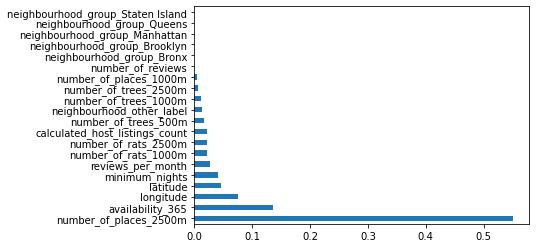

In [33]:
pd.Series(reg_tree_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

## Random Forest

In [34]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 25) 	Testing Features Shape:	 (9743, 25)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [35]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [37]:
df_reg_forest = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,63.326787,8.350181,0.246816,0.018613,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.041381,-67.955912,-68.649789,-67.086198,-67.183769,-67.583410,0.628753,1
3,42.833217,2.964270,0.180167,0.033986,mse,10,150,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.062900,-67.981031,-68.638530,-67.115843,-67.145134,-67.588688,0.624960,2


In [38]:
reg_forest_best = reg_seach.best_estimator_
y_pred = reg_forest_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 69.0997


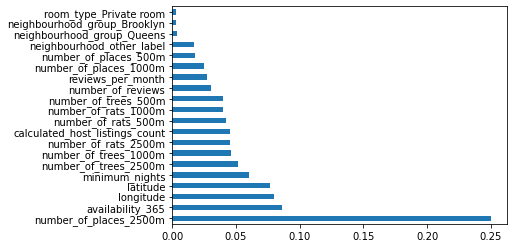

In [39]:
pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20).plot(kind='barh')
plt.show()

## Random Forest with feature selection

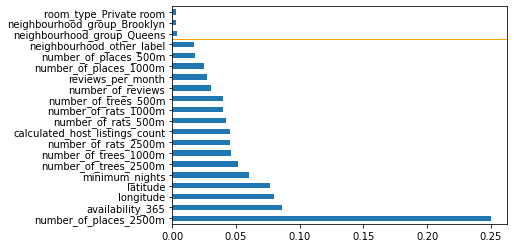

In [40]:
df_reg_forest_feat_im = pd.Series(reg_forest_best.feature_importances_, index=features.columns).nlargest(20)
threshold_feat_im = 0.005


threshold_plot = len(df_reg_forest_feat_im[df_reg_forest_feat_im>=threshold_feat_im])-0.5

df_reg_forest_feat_im.plot(kind='barh')
plt.axhline(y=threshold_plot,linewidth=1, color='orange')
plt.show()

In [41]:
#chose which featues not to include in the calculation
features_select = features.drop(df_reg_forest_feat_im[df_reg_forest_feat_im<threshold_feat_im].index, axis=1)
target = df.price

print(features_select.columns)

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_other_label',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Shared room', 'number_of_places_2500m',
       'number_of_places_1000m', 'number_of_places_500m',
       'number_of_rats_2500m', 'number_of_rats_1000m', 'number_of_rats_500m',
       'number_of_trees_2500m', 'number_of_trees_1000m',
       'number_of_trees_500m'],
      dtype='object')


In [42]:
test_fraction = 0.2

# This is a stratified split:
X_train, X_test, y_train, y_test = train_test_split(features_select, target, test_size = test_fraction, random_state=3546)
#Display how many samples are chosen for training and test, respectively
print('Training Features Shape:', X_train.shape,'\tTesting Features Shape:\t', X_test.shape)
print('Training Labels Shape:\t', y_train.shape, '\tTesting Labels Shape:\t', y_test.shape)

Training Features Shape: (38970, 22) 	Testing Features Shape:	 (9743, 22)
Training Labels Shape:	 (38970,) 	Testing Labels Shape:	 (9743,)


In [43]:
parameters = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('mse',), 'max_depth':[10, 20, None]} # mae is again more than 60 times slower than mse

reg_forest_select = RandomForestRegressor(random_state=3546) # random state is set so as to guarantee the same outcome every time
reg_seach = GridSearchCV(reg_forest_select, parameters, scoring='neg_mean_absolute_error', refit=True, )#verbose=4)

reg_seach.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=3546),
             param_grid={'criterion': ('mse',), 'max_depth': [10, 20, None],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [44]:
df_reg_forest_select = pd.DataFrame(reg_seach.cv_results_).sort_values('rank_test_score')
df_reg_forest_select.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,44.050027,3.481482,0.220304,0.037563,mse,10,200,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.031876,-67.894591,-68.587952,-67.103827,-67.156102,-67.554869,0.603100,1
3,34.568878,1.781484,0.155194,0.016202,mse,10,150,"{'criterion': 'mse', 'max_depth': 10, 'n_estim...",-67.047618,-67.901288,-68.558159,-67.129507,-67.156835,-67.558681,0.587059,2


In [45]:
reg_forest_select_best = reg_seach.best_estimator_
y_pred = reg_forest_select_best.predict(X_test)

print(f'Mean absolute error (on test data): {round(mean_absolute_error(y_test, y_pred),4)}')

Mean absolute error (on test data): 69.069


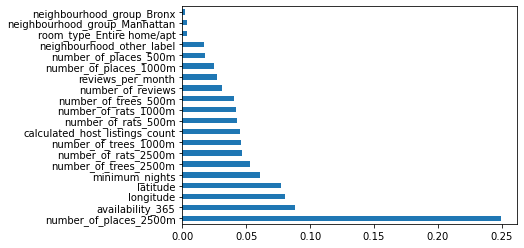

In [46]:
pd.Series(reg_forest_select_best.feature_importances_, index=features_select.columns).nlargest(20).plot(kind='barh')
plt.show()

In [54]:
%store reg_seach
#restore with %store -r reg_seach

Stored 'reg_seach' (GridSearchCV)
